In [ ]:
import cv2
import os, fnmatch
import numpy as np
import time
import matplotlib.pyplot as plt
from utils import FeatureExtractor
from utils import SVC
from utils import get_feature
%matplotlib inline

In [ ]:
# Get name
def get_file_names(src_path='./', pattern='*.jpeg'):
    # Return a list of file names in a given folder with certain pattern
    # images = glob.glob('../data/**.jpeg')
    images = []
    for root, dir_names, file_names in os.walk(src_path):
        for filename in fnmatch.filter(file_names, pattern):
            images.append(os.path.join(root, filename))
    return images

In [ ]:
# Import car and not car images
cars = get_file_names('./data/vehicles', pattern='*.png')[0:100]
not_cars = get_file_names('./data/non-vehicles', pattern='*.png')[0:100]

In [ ]:
# Calculate car features & not-car features
t = time.time()
print("Calculating features for {} images...".format(len(cars)+len(not_cars)))
car_features = get_feature(cars, workers=4)
not_car_features = get_feature(not_cars, workers=4)
print("Completed calculating feature in {:f} seconds\n".format((time.time() - t), 3))

In [ ]:
# Create data set
x = np.vstack((car_features, not_car_features)).astype(np.float64)
y = np.concatenate((np.ones(len(car_features)), np.zeros(len(not_car_features))))
print("Car Feature Vector's length: ", len(car_features))
print("Not Car Feature Vector's length: ", len(not_car_features))

In [ ]:
# Training using SVC Classifier
svc = SVC(x, y, test_split=0.01)
svc.train()
svc.score()

In [ ]:
# Create a list of Windows
def create_windows(x_region=[None, None], y_region=[None, None], 
                  xy_window=(64, 64), xy_overlap=(0.5, 0.5)):

    if x_region[0] is None:
        x_region[0] = 0
    if x_region[1] is None:
        x_region[1] = 0
    if y_region[0] is None:
        y_region[0] = 0
    if y_region[1] is None:
        y_region[1] = 0
    # Compute the region of interest
    x = x_region[1] - x_region[0]
    y = y_region[1] - y_region[0]

    # Step size
    x_pix_per_step = np.int(xy_window[0]*(1-xy_overlap[0]))
    y_pix_per_step = np.int(xy_window[1]*(1-xy_overlap[1]))

    # Total windows
    x_windows = np.int(x/x_pix_per_step) - 1
    y_windows = np.int(y/y_pix_per_step) - 1

    windows = []
    for ys in range(y_windows):
        for xs in range(x_windows):
            # Calculate window pos
            startx = xs*x_pix_per_step + x_region[0]
            endx = startx + xy_window[0]

            starty = ys*y_pix_per_step + y_region[0]
            endy   = starty + xy_window[1]

            # Append window to list
            windows.append(((startx, starty),(endx, endy)))

    return windows

def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    draw_img = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(draw_img, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return draw_img


In [ ]:
test_img = cv2.imread('./test_images/test1.jpg')
r, c, n = test_img.shape
windows = create_windows(x_region=[0, c], y_region=[0, r], xy_window=(64, 64), xy_overlap=(0, 0))
print"Number of windows: ", len(windows)

# Draw image
draw_img = np.copy(test_img)
draw_img = draw_boxes(draw_img, windows, color=(0, 255, 255), thick=3)

a = plt.figure( figsize =(30, 20))
plt.imshow(draw_img)

In [1]:
import cv2
import os, fnmatch
import numpy as np
import time
import matplotlib.pyplot as plt
from utils import FeatureExtractor
from utils import SVC
from utils import get_feature
%matplotlib inline

In [2]:
import glob
from utils import draw_windows
from utils import CameraCalibrator, ProjectionManager, LineTracker, ImageFilter, DiagnosticMgr

2


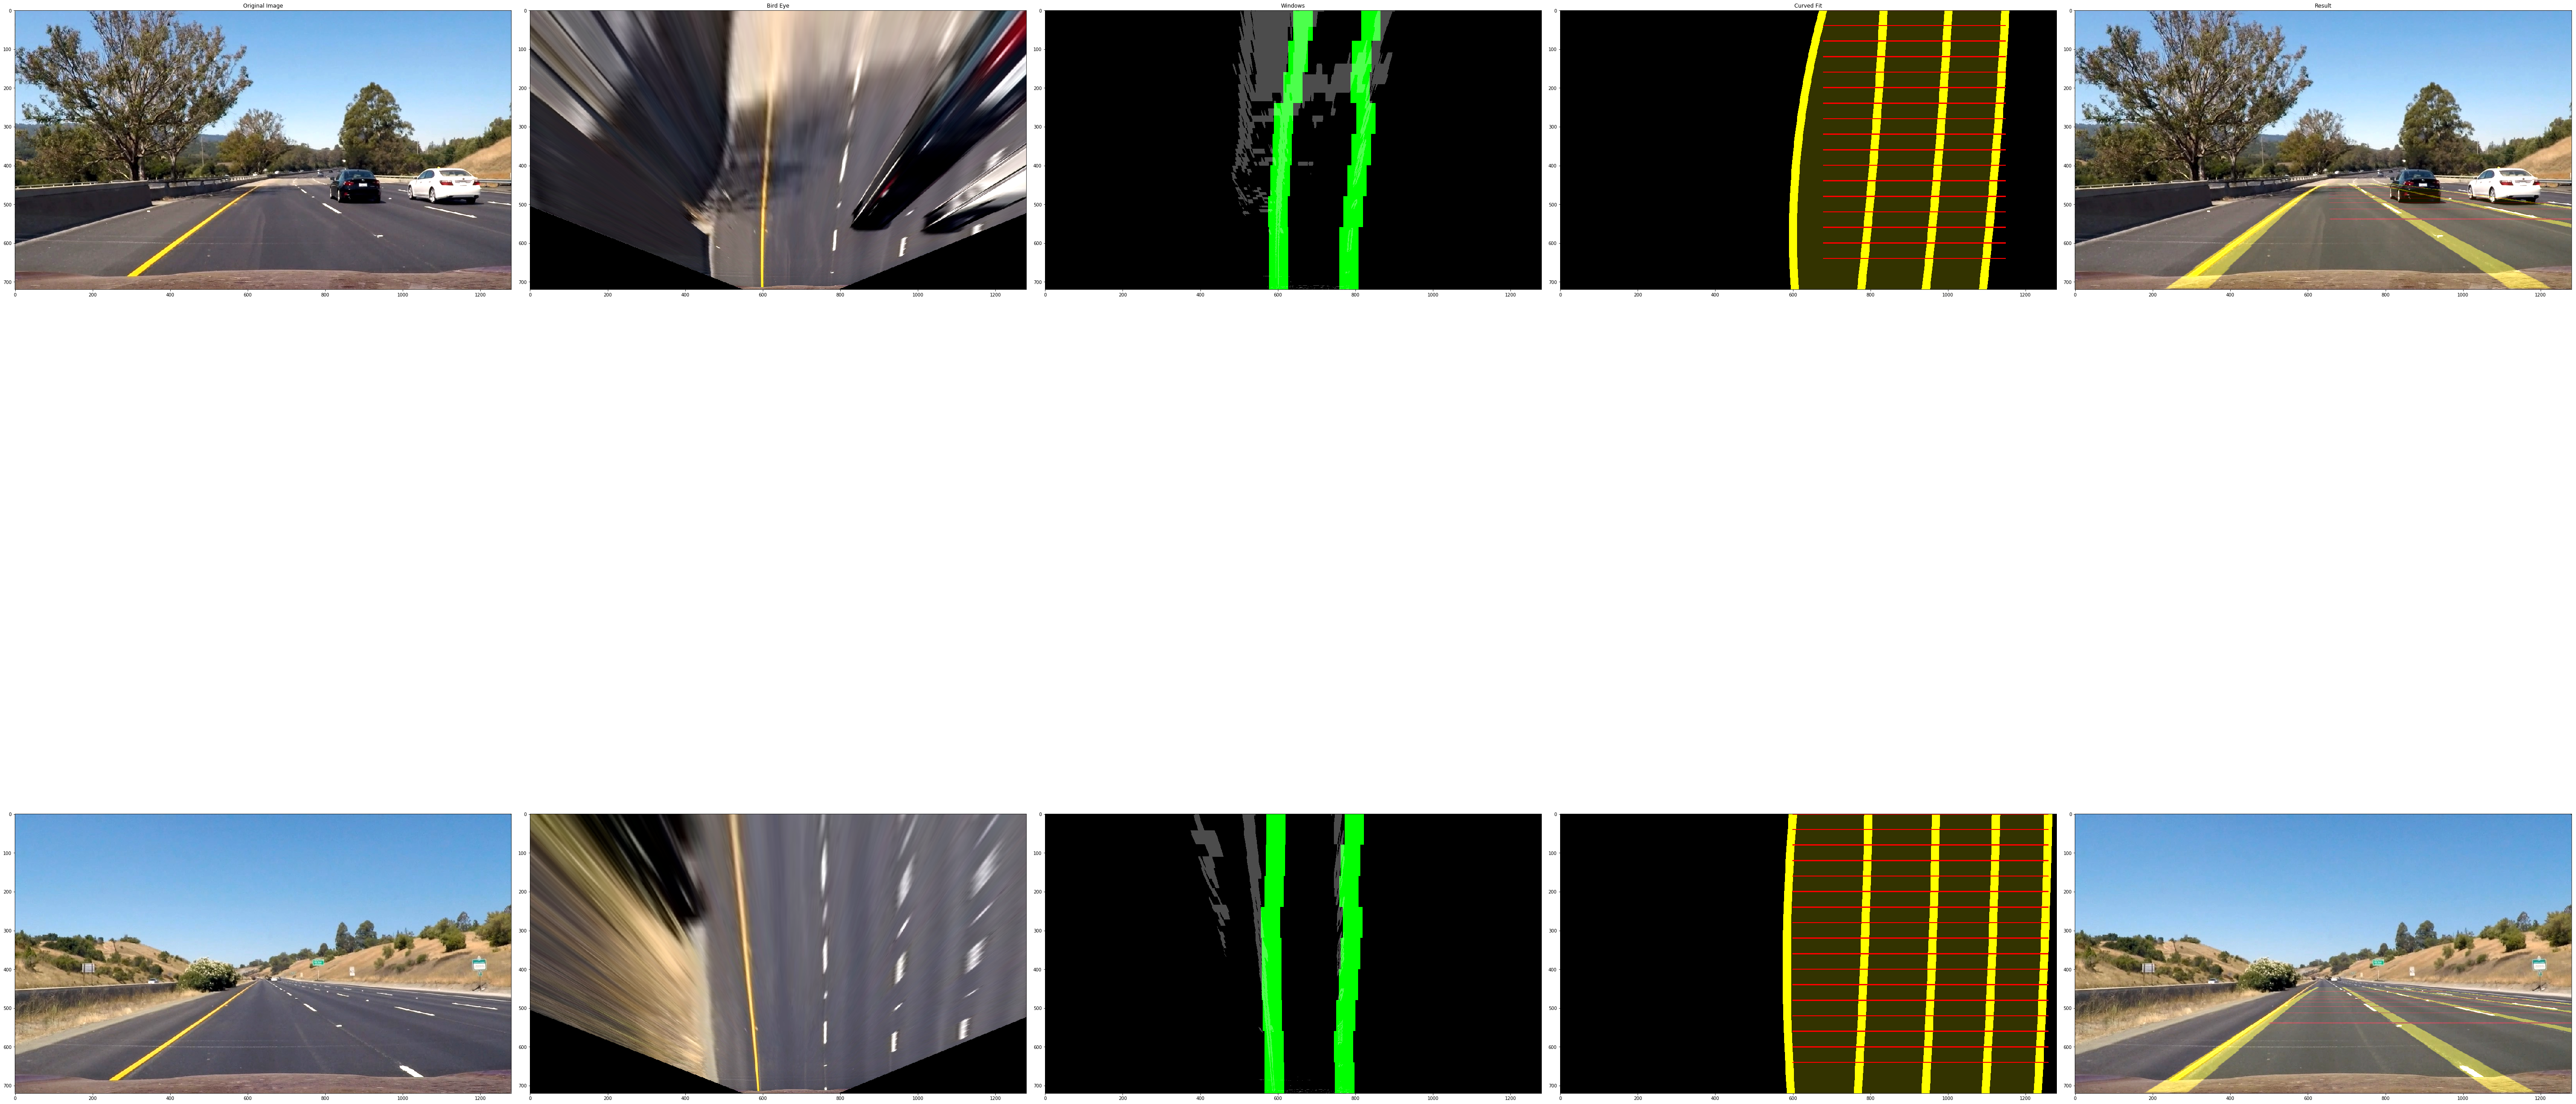

In [23]:
# Try different approach in Project 4
curve_centers = LineTracker(window_height=80, window_width=20, margin=25, ym=10/720, xm=4/384, smooth_factor=15)

def draw_line_segments(source_image, h_lines, color=[255, 0, 0], thickness=2):
    """
    Draw the line segments to the source images.
    """
    line_img = np.copy(source_image)
    for  left, right in h_lines:
            cv2.line(line_img, (left[0],left[1]), (right[0],right[1]), color, thickness)
    return line_img

def lane_detection(frame):
    global curve_centers
    r, w, c = frame.shape
    img_filter = ImageFilter((r, w))
    projmgr = ProjectionManager(cam_calib=None, row=r, col=w,src=None, dst=None, offset=370)
    # I did not use cam calibration on this project
    undst_img = frame
    # Make a lane region brighter
    # undst_roi = img_filter.region_of_interest(undst_img, projmgr.get_roi())
    undst_roi = undst_img
    undst_img = cv2.addWeighted(undst_img, 0.5, undst_roi, 0.7, 0.)
    
    # Create a binary image
    bin_img = img_filter.mix_color_grad_thresh(undst_img, grad_thresh=(30, 100), s_thresh=(88, 250),  h_thresh=(120, 250))    
    
    # Perspective Transform
    binary_roi = img_filter.region_of_interest(bin_img, projmgr.get_roi())
    birdseye_view = projmgr.get_birdeye_view(undst_img)
    birdseye_img = projmgr.get_birdeye_view(binary_roi)
    histogram = np.sum( birdseye_img [ birdseye_img .shape[0]/2:,:], axis=0)
 
    # # Sliding window
    window_centroids = curve_centers.find_lane_line(warped=birdseye_img)
    windows, left_x, right_x = draw_windows(birdseye_img, w=25, h=80, window_centroids=window_centroids)

    # Curve-fit and calculate curvature and offset
    curved_fit, lines, lanes = curve_centers.curve_fit(windows, (left_x, right_x), transparency=0.2)
    
    for lane in zip(lines,lines[1:]):
        l = curve_centers.create_windows(1280, 720, lane[0], lane[1],y_step=40)
        curved_fit = draw_line_segments(curved_fit, l)
    
    # Convert back to normal vieward
    lane_lines = projmgr.get_normal_view(curved_fit)

    # Merge to original image
    lane_lines = cv2.addWeighted(undst_img, 1.0, lane_lines, 0.4, 0.0)
    return undst_img, lane_lines, windows, curved_fit, birdseye_view, histogram,  lines, lanes


images = glob.glob('./test_images/*.jpg')[0:2]
size = len(images)
print(size)
f, ax = plt.subplots(size, 5, figsize =(80,50))
f.tight_layout()
ax[0, 0].set_title('Original Image')
ax[0, 1].set_title('Bird Eye')
ax[0, 2].set_title('Windows')
ax[0, 3].set_title('Curved Fit')
ax[0, 4].set_title('Result')
lines = []
lanes = []
for idx, img in enumerate(images):
    frame = cv2.cvtColor(cv2.imread(img), cv2.COLOR_BGR2RGB)
    undst_img, lane_lines, windows, curved_fit, birdseye_view,histogram ,lines, lanes  = lane_detection(frame)
    ax[idx, 0].imshow(undst_img)
    ax[idx, 1].imshow(birdseye_view)
    # ax[idx, 1].plot(histogram)
    ax[idx, 2].imshow(windows)
    ax[idx, 3].imshow(curved_fit)
    ax[idx, 4].imshow(lane_lines)


In [ ]:
# Create a series of orthogonal lines in each lane. In order to find a diagonal line, we use the curve fit function
# to find the angle to the lines compared to lane
def create_lines(img, lanes, width=None, angle=45, density=30):
    